# AI in medicine - CADD exercise

- **Tutor:** David Schaller, AG Volkamer, Charité - Universitätsmedizin Berlin (david.schaller@charite.de)
- **Target audience**: Medical students from Charité

This notebook is based on [TeachOpenCADD](https://github.com/volkamerlab/TeachOpenCADD/) and the scikit-learn [intro](https://github.com/volkamerlab/ai_in_medicine) from week 1.

## Aim

In this notebook, the experience gained in the first week will be applied to perform a virtual screening experiment for inhibitors of the epidermal growth factor receptor ([EGFR](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor)) via machine learning. First, computer-friendly molecular representations will be introduced, which allow the training of machine learning models. Next, a support vector machine will be trained to classify molecules as active or inactive. The trained model will be used to predict the activity of a small molecule set. Finally, successful participants can check their hits for potential activity against EGFR via online resources.

## Learning goals

- apply knowledge from first week
- represent molecules in a computer-friendly fashion
- perform a virtual screening experiment
- check online resources for potential activities

## Theory
The essential theory of machine learning algorithms was covered in the first week. The concept of virtual screening will be presented seperately via slides.

## References
- [epidermal growth factor receptor](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor)
- [molecular fingerprints](http://infochim.u-strasbg.fr/CS3/program/material/Bajorath.pdf)
- [support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine)
- [virtual screening](https://en.wikipedia.org/wiki/Virtual_screening)
- [TeachOpenCADD](https://github.com/volkamerlab/TeachOpenCADD/)
- [scikit-learn Intro from week 1](https://github.com/volkamerlab/ai_in_medicine)

## Python packages
- [scikit-learn](https://scikit-learn.org/stable/)
- [rdkit](https://www.rdkit.org/)
- [pandas](https://pandas.pydata.org/)
- [numpy](https://numpy.org/)
- [matplotlib](https://matplotlib.org/)

## Practical

**Content**

1. Install RDKit  
2. Import modules  
3. Data preparation  
 3.1 Load data  
 3.2 Interpret molecules  
4. Classify data  
5. Split data  
6. Train a support vector classifier
7. Assess performance
8. Apply to unknown molecules

### 1. Install RDKit

RDKit is not installed in Google Colab, and RDKit is only available via `conda` (a package manager), which is not available on Colab either. To provide RDKit, we will need to (1) Install conda (we will use `condacolab` for that) and (2) Install RDKit using `mamba`.

In [1]:
!pip install condacolab
import condacolab
condacolab.install()

  Using cached condacolab-0.1.9-py3-none-any.whl.metadata (5.6 kB)
Using cached condacolab-0.1.9-py3-none-any.whl (7.2 kB)
✨🍰✨ Everything looks OK!


In [2]:
!mamba install -yq rdkit

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


### 2. Import modules

These modules are needed to perform all parts of this exercise. Feel free to add other modules, since there are multiple solutions to succeed.

In [3]:
#data handling
import numpy as np
import pandas as pd

# chemistry
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D

# machine learning
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt

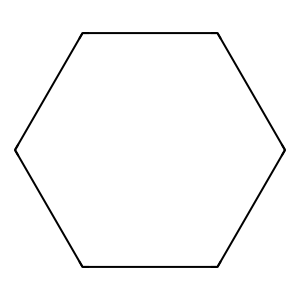

In [11]:
from rdkit import Chem
from rdkit.Chem import Draw

# Créer une molécule à partir de la représentation SMILES
smiles = "C1CCCcC1"  # Éthanol
mol = Chem.MolFromSmiles(smiles)

# Afficher la structure moléculaire
Draw.MolToImage(mol)


### 3. Data preparation

In [12]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Exemple de SMILES pour un inhibiteur de l'EGFR (comme l'Erlotinib)
smiles = 'CC1=NC2=C(C(=O)N1)C(=O)N2C3=CC=CC=C3'  # SMILES de l'Erlotinib

# Créer l'objet molécule à partir de SMILES
mol = Chem.MolFromSmiles(smiles)

# Calculer des descripteurs moléculaires
poids_molaire = Descriptors.MolWt(mol)  # Poids moléculaire
logp = Descriptors.MolLogP(mol)  # LogP (lipophilie)
nb_h_donneurs = Descriptors.NumHDonors(mol)  # Nombre de donneurs de liaisons hydrogène
nb_h_accepteurs = Descriptors.NumHAcceptors(mol)  # Nombre d'accepteurs de liaisons hydrogène

print(f'Poids moléculaire: {poids_molaire}')
print(f'LogP: {logp}')
print(f'Nombre de donneurs de liaisons hydrogène: {nb_h_donneurs}')
print(f'Nombre d\'accepteurs de liaisons hydrogène: {nb_h_accepteurs}')


Poids moléculaire: 227.223
LogP: 1.37022
Nombre de donneurs de liaisons hydrogène: 1
Nombre d'accepteurs de liaisons hydrogène: 3


#### 3.1 Load data

We will use a subset of molecules retrieved from the [ChEMBL](https://www.ebi.ac.uk/chembl/) database, which contains ~5k molecules with reported activity against EGFR. The whole ChEMBL database currently contains ~16 million datapoints for ~2 million compounds.

***Insert code to load the data found in `data/egfr_chembl25.csv` into a pandas dataframe named 'df' and display the first few rows.***

In [13]:
# Read activity data for EGFR into a pandas dataframe named df
egfr_chembl25_link = 'https://github.com/volkamerlab/ai_in_medicine/raw/master/data/egfr_chembl25.csv'
# load the csv file as a pandas dataframe
df = pd.read_csv("https://github.com/volkamerlab/ai_in_medicine/raw/master/data/egfr_chembl25.csv")

df.head()

,chembl_id,smiles,IC50[nM]
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,77.00
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,330.00
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,1.00
3,CHEMBL504034,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,40.00
4,CHEMBL158797,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,43000.01


The dataframe contains information about the ChEMBL ID, which can be used to query the ChEMBL database, a molecule in the form of a SMILES string and an activity value in the form of IC50 in nM. The IC50 describes the molar concentration that will result in 50 percent of inhibition in-vitro.

#### 3.2 Interpret molecules

Next, we will interpret the molecules that are stored as SMILES strings and transform them in a format that a machine learning algorithm can handle. The [RDKit](https://www.rdkit.org/) library is a free open-source framework that can be used to work with molecular data. In the following cells you will learn a few basic functionalities from RDKit and how you can store substructures of molecules in computer-friendly bit vectors, that can be later used to train your model.

Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1


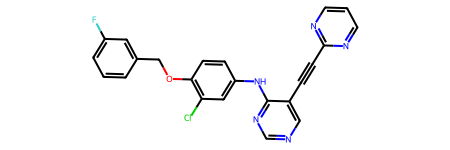

In [14]:
# pick the first SMILES stored in the dataframe and display the molecule with RDKit
print(df['smiles'][0])
mol = Chem.MolFromSmiles(df['smiles'][0])
mol

The SMILES (**S**implified **M**olecular **I**nput **L**ine **E**ntry **S**ystem) representation allows to store the types and connectivity of atoms in a single string.  
**Atom types** are represented by their atomic symbols, upper case letters represent aliphatic atoms, lower case letters represented aromatic atoms, hydrogens are often stripped away, since those can be inferred from atom type and connectivity:  
`C` - aliphatic (sp3) carbon  
`n` - aromatic (sp2) nitrogen  
**Bonds** are only represented if needed:  
`-` - single bond (`CC` and `C-C` are the same, since single bonds are used by default)  
`=` - double bond (`C=C-C=C` and `cccc` are the same)  
`#` - triple bond  
**Ring** opening and closures are represented with numbers:  
`c1ccccc1` - benzene  
**Substituents** leaving a chain or ring are represented with brackets:  
`c1cc(C)ccc1` - methyl-substituted benzene.  
`CC(F)(Br)Cl`  - ethane substituted with fluorine, chlorine and bromine

**With the rules from above, you should be able to create the SMILES for acetylsalicylic acid, the active ingredient of Aspirin.**

<img src='https://github.com/volkamerlab/ai_in_medicine/blob/master/images/aspirin.png?raw=1'>

2D representation of acetylsalicylic acid taken from [Wikipedia](https://en.wikipedia.org/wiki/Aspirin#/media/File:Aspirin-skeletal.svg).

In [ ]:
# Write the smiles for acetylsalicylic acid
####################

####################

Molecules can be represented in form of [molecular fingerprints](http://infochim.u-strasbg.fr/CS3/program/material/Bajorath.pdf), which store the presence of substructures in a bit vector consisting of zeros and ones. Here we will use Molecular ACCess System (MACCS) keys, which are implemented in RDKit and record the presence of a predefined set of substructures.

In [15]:
maccs_keys = list(MACCSkeys.GenMACCSKeys(mol))
print(maccs_keys)
print('Zeros:', len(maccs_keys) - sum(maccs_keys))
print('Ones:', sum(maccs_keys))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Zeros: 129
Ones: 38


Let's explore which substrucutres can be found in our sample molecule.

In [16]:
# Get indices of ones
maccs_key_series = pd.Series(maccs_keys)
maccs_key_series[maccs_key_series==1].index

Index([ 17,  38,  42,  65,  77,  80,  87,  98, 103, 107, 109, 113, 120, 121,
       125, 126, 127, 133, 134, 135, 137, 142, 143, 144, 145, 150, 151, 152,
       153, 155, 156, 157, 158, 161, 162, 163, 164, 165],
      dtype='int64')

The underlying substructures are provided in RDKit via a dictionary and are represented as [SMARTS](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html), which is an extension of the SMILES language and especially useful for substructure searches. The SMARTS of bit 80 represents the substructure `[#7]~*~*~*~[#7]`.
- `#7` - any nitrogen
- `~` - any bond
- `*` - any atom

We can also visualize substructures with the following lines. Just replace the `bit_index` with any of the indices found above.

In [ ]:
bit_index = 80
smarts = MACCSkeys.smartsPatts[bit_index][0]
Chem.MolFromSmarts(smarts)

Next, let's use the following function to add an RDKit representation and the MACCS keys for each of the SMILES in the data set.

In [17]:
def add_mols_and_maccs(df, smiles_column='smiles'):
    """
    Generate rdkit molecule objects and MACCSkeys and add them to the given dataframe.

    Parameters
    ----------
    df: pandas.DataFrame
        A data frame containing a column with SMILES.
    """
    df['mol'] = df[smiles_column].apply(Chem.MolFromSmiles)
    df['maccs'] = df['mol'].apply(MACCSkeys.GenMACCSKeys)
    return

In [18]:
# add columns for rdkit molecules and maccs keys
add_mols_and_maccs(df)
display(df.head())

,chembl_id,smiles,IC50[nM],mol,maccs
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,77.00,<rdkit.Chem.rdchem.Mol object at 0x7a6e4456f3e0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,330.00,<rdkit.Chem.rdchem.Mol object at 0x7a6e4456fb50>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,1.00,<rdkit.Chem.rdchem.Mol object at 0x7a6e4456f990>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL504034,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,40.00,<rdkit.Chem.rdchem.Mol object at 0x7a6e4456fc30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL158797,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,43000.01,<rdkit.Chem.rdchem.Mol object at 0x7a6e4456fca0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


### 4. Classify data

To train a machine learning model to classify molecules as active or inactive, we need to add an activity label to our data set.

***Insert code below that adds a column named 'active' to the dataframe that holds the value 1.0 if the IC50 is lower than 500 and otherwise 0.0.***

In [20]:
# Mark every molecule as active with an IC50 < 500
df['active'] = df['IC50[nM]'].apply(lambda x: 1.0 if x < 500 else 0.0)

####################

The following lines should find 2762 actives and 2147 inactives.

In [21]:
print('Actives:', int(df['active'].sum()))
print('Inactives:', int(len(df)-df['active'].sum()))

Actives: 2762
Inactives: 2147


### 5. Split data

***Split the data into training and test set by using the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.***

In [24]:
import numpy as np

# Convertir en tableaux NumPy (facultatif, mais permet d'utiliser .shape)
x = np.array(df['maccs'].to_list())
y = np.array(df['active'].to_list())

# Afficher les dimensions (formes) des tableaux
print("Dimensions de x:", x.shape)
print("Dimensions de y:", y.shape)

# Alternativement, vous pouvez utiliser len() si vous travaillez avec des listes :
print("Longueur de x:", len(x))
print("Longueur de y:", len(y))


Dimensions de x: (4909, 167)
Dimensions de y: (4909,)
Longueur de x: 4909
Longueur de y: 4909


In [25]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test (80% / 20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Afficher les dimensions des ensembles d'entraînement et de test
print(f"Taille du jeu d'entraînement x: {x_train.shape}, y: {y_train.shape}")
print(f"Taille du jeu de test x: {x_test.shape}, y: {y_test.shape}")


Taille du jeu d'entraînement x: (3927, 167), y: (3927,)
Taille du jeu de test x: (982, 167), y: (982,)


### 6. Train a support vector classifier

***Train a [support vector classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).***

In [28]:
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Préparer les caractéristiques (features) et les étiquettes (labels)
x = np.array(df['maccs'].to_list())  # Liste des empreintes moléculaires
y = np.array(df['active'].to_list())  # Liste des étiquettes (actif/inactif)

# Diviser les données en ensembles d'entraînement et de test (80% pour l'entraînement, 20% pour le test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Vérification des formes des ensembles
print(f"Ensemble d'entraînement x: {x_train.shape}, y: {y_train.shape}")
print(f"Ensemble de test x: {x_test.shape}, y: {y_test.shape}")

# Créer une instance du classificateur SVC
svc = SVC(kernel='linear', random_state=42)  # Vous pouvez changer le kernel selon le type de SVC (linéaire, RBF, etc.)

# Entraîner le modèle sur les données d'entraînement
svc.fit(x_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = svc.predict(x_test)


Ensemble d'entraînement x: (3927, 167), y: (3927,)
Ensemble de test x: (982, 167), y: (982,)


### 7. Assess performance

- ***[predict](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict) the activity of the test set***  
- ***assess the performance of your model by plotting a [ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and calcuation of the [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)***

In [29]:
# predict the activity of the test set
y_pred = svc.predict(x_test)

####################

In [30]:
# calculate AUC
# Calculer les scores de décision (plutôt que les classes) pour l'AUC
y_scores = svc.decision_function(x_test)  # Pour SVC, on utilise decision_function pour obtenir les scores

# Calcul de l'AUC
auc = roc_auc_score(y_test, y_scores)
print(f"AUC : {auc:.4f}")

####################

AUC : 0.8468


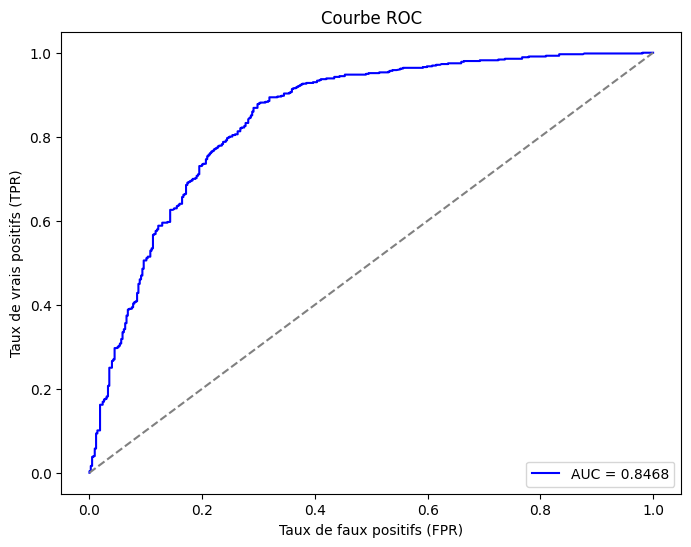

In [31]:
# plot the ROC curve
# Calculer les taux de vrais positifs et de faux positifs pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale aléatoire (auc = 0.5)
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.legend(loc='lower right')
plt.show()


####################

### 8. Apply to unknown molecules

***Use your model and predict the activity of a set of unknown molecules located at*** `data/egfr_candidates.csv`***.***

In [33]:
# load data and assign maccs keys
egfr_candidates_link = 'https://github.com/volkamerlab/ai_in_medicine/raw/master/data/egfr_candidates.csv'
# Load data from the URL
egfr_candidates_link = 'https://github.com/volkamerlab/ai_in_medicine/raw/master/data/egfr_candidates.csv'
data = pd.read_csv(egfr_candidates_link)

# Check the first few rows of the data
print(data.head())

def calculate_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return list(MACCSkeys.GenMACCSKeys(mol))
    else:
        return None

# Create a new column for MACCS keys
data['maccs_keys'] = data['smiles'].apply(calculate_maccs)

# Display the data with the new column
print(data.head())

                                              smiles
0  COC1=C(OCCC[NH+]2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C...
1  COCCOC1=CC2=C(C=C1OCCOC)C(NC1=CC(=CC=C1)C#C)=N...
2  C[NH+](C)C\C=C\C(=O)NC1=C(OC2CCOC2)C=C2N=CN=C(...
3  CS(=O)(=O)CCNCC1=CC=C(O1)C1=CC2=C(C=C1)N=CN=C2...
4  CCOC1=C(NC(=O)C=CC[NH+](C)C)C=C2C(NC3=CC(Cl)=C...
                                              smiles  \
0  COC1=C(OCCC[NH+]2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C...   
1  COCCOC1=CC2=C(C=C1OCCOC)C(NC1=CC(=CC=C1)C#C)=N...   
2  C[NH+](C)C\C=C\C(=O)NC1=C(OC2CCOC2)C=C2N=CN=C(...   
3  CS(=O)(=O)CCNCC1=CC=C(O1)C1=CC2=C(C=C1)N=CN=C2...   
4  CCOC1=C(NC(=O)C=CC[NH+](C)C)C=C2C(NC3=CC(Cl)=C...   

                                          maccs_keys  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


In [38]:
# predict the activity
x_new = np.array(data['maccs_keys'].to_list())
predictions = svc.predict(x_new)

# Ajouter les prédictions au DataFrame
data['predicted_activity'] = predictions

# Afficher les résultats
print("Résultats des prédictions :")
print(data[['smiles', 'predicted_activity']])

# Sauvegarder les résultats dans un fichier CSV
data.to_csv('egfr_candidates_predictions.csv', index=False)
print("Résultats sauvegardés dans 'egfr_candidates_predictions.csv'.")

Résultats des prédictions :
                                              smiles  predicted_activity
0  COC1=C(OCCC[NH+]2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C...                 1.0
1  COCCOC1=CC2=C(C=C1OCCOC)C(NC1=CC(=CC=C1)C#C)=N...                 1.0
2  C[NH+](C)C\C=C\C(=O)NC1=C(OC2CCOC2)C=C2N=CN=C(...                 1.0
3  CS(=O)(=O)CCNCC1=CC=C(O1)C1=CC2=C(C=C1)N=CN=C2...                 1.0
4  CCOC1=C(NC(=O)C=CC[NH+](C)C)C=C2C(NC3=CC(Cl)=C...                 1.0
5  COC1=C(NC2=NC=C(Cl)C(NC3=CC=CC=C3P(C)(C)=O)=N2...                 1.0
6  C#CC1=CC(=CC=C1)NC2=NC=NC3=CC4=C(C=C32)OCCOCCO...                 1.0
7  COC1=C(NC2=NC=CC(=N2)C2=CN(C)C3=CC=CC=C23)C=C(...                 1.0
Résultats sauvegardés dans 'egfr_candidates_predictions.csv'.


In [40]:
import pandas as pd
from google.colab import files

# Sauvegarder le fichier dans un format Excel
excel_filename = 'egfr_candidates_predictions.xlsx'
data.to_excel(excel_filename, index=False, engine='openpyxl')

# Télécharger le fichier Excel
files.download(excel_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
from google.colab import files

# Sauvegarder le fichier localement
data.to_csv('egfr_candidates_predictions.csv', index=False)

# Télécharger le fichier sur votre machine locale
files.download('egfr_candidates_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***Visit [PubChem](https://pubchem.ncbi.nlm.nih.gov/), an online resource for chemical information, and query the database with a SMILES of a predicted active and predicted inactive. What can you find out about the molecules?***